## Import packages you need


In [1]:
# Import necessary packages.
import os
import copy
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, SubsetRandomSampler
from torchvision.datasets import DatasetFolder
from sklearn.model_selection import KFold

# If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


/home/alex/miniconda3/envs/4016/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Show current device name


In [2]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Dataset, Data Loader, and Transforms


In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.RandomResizedCrop((128, 128)),
    # transforms.RandomCrop(size=128, padding=10),

    # Randomly flip and rotate the image
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomInvert(),

    # Randomly adjust the brightness and contrast of the image
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),

    # Convert the image to a tensor
    transforms.RandAugment(),
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 48

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../data/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../data/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../data/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("../data/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Model

model = torchvision.models.resnet18(pretrained=False) → This is fine.

model = torchvision.models.resnet18(pretrained=True) → This is NOT allowed.


## Training


In [4]:
def get_pseudo_labels(dataset, model, threshold=0.65):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    # Iterate over the dataset by batches.
    for batch in tqdm(dataloader):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # you may filter the data and construct a new dataset here.

    # # Turn off the eval mode.
    model.train()
    return dataset


In [5]:
def model_snapshot(model, new_file=None, old_file=None):
    if os.path.exists(old_file) is True:
        os.remove(old_file)
    torch.save(model, new_file)


In [6]:
def trainModel(model, n_epochs, do_semi, device, criterion, optimizer, train_loader, valid_loader):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    bestAcc = 0.
    bestLoss = 100.
    bestEpoch = 0
    bestModel = None

    for epoch in range(n_epochs):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        if do_semi:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model, 0.95)

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

        # Save the loss and accuracy for each epoch.
        history['train_loss'].append(train_loss)
        history['val_loss'].append(valid_loss)
        history['train_acc'].append(train_acc.cpu())
        history['val_acc'].append(valid_acc.cpu())

        # Dont ask, this is the only way to round the number for some reason
        if float(f"{valid_acc:.5f}") > float(f"{bestAcc:.5f}") and round(valid_loss, 5) < round(bestLoss, 5):
            model_snapshot(model.state_dict(), new_file=f"{epoch + 1}_{valid_acc}.pth", old_file=f"{bestEpoch + 1}_{bestAcc}.pth")
            bestAcc = valid_acc
            bestLoss = valid_loss
            bestEpoch = epoch
            bestModel = copy.deepcopy(model)

        if epoch - bestEpoch > 50:
            break

    # Return model and history for later use.
    return bestModel, history


In [7]:
def plotLoss(history):
    plt.plot([*range(1, len(history['train_loss']) + 1)], history['train_loss'])
    plt.plot([*range(1, len(history['val_loss']) + 1)], history['val_loss'])
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend(labels=['Train', 'Validation'])


In [8]:
def plotAcc(history):
    plt.plot([*range(1, len(history['train_acc']) + 1)], history['train_acc'])
    plt.plot([*range(1, len(history['val_acc']) + 1)], history['val_acc'])
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(labels=['Train', 'Validation'])


In [9]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# modelPath = "model/modelName/savedName.pth"
model = torchvision.models.efficientnet_v2_l(weights=None).to(device)
# model.load_state_dict(torch.load(modelPath, map_location=device))
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 500

# Whether to do semi-supervised learning.
do_semi = False


In [10]:
bestdModel, history = trainModel(model, n_epochs, do_semi, device, criterion, optimizer, train_loader, valid_loader)
lastModel = model


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 001/500 ] loss = 5.15460, acc = 0.09660


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 001/500 ] loss = 3.69530, acc = 0.06002


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 002/500 ] loss = 2.56639, acc = 0.09796


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 002/500 ] loss = 2.87468, acc = 0.10466


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 003/500 ] loss = 2.48233, acc = 0.10084


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 003/500 ] loss = 2.44841, acc = 0.09325


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 004/500 ] loss = 2.47087, acc = 0.09448


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 004/500 ] loss = 2.41922, acc = 0.11706


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 005/500 ] loss = 2.46325, acc = 0.09055


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 005/500 ] loss = 2.40600, acc = 0.09425


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 006/500 ] loss = 2.43566, acc = 0.09357


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 006/500 ] loss = 2.40314, acc = 0.10317


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 007/500 ] loss = 2.42669, acc = 0.08389


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 007/500 ] loss = 2.40448, acc = 0.10813


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 008/500 ] loss = 2.41894, acc = 0.09262


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 008/500 ] loss = 2.42766, acc = 0.08829


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 009/500 ] loss = 2.42107, acc = 0.08913


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 009/500 ] loss = 2.39261, acc = 0.10466


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 010/500 ] loss = 2.40814, acc = 0.11748


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 010/500 ] loss = 2.38126, acc = 0.11954


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 011/500 ] loss = 2.41345, acc = 0.10381


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 011/500 ] loss = 2.37605, acc = 0.12252


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 012/500 ] loss = 2.40078, acc = 0.10497


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 012/500 ] loss = 2.37453, acc = 0.13244


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 013/500 ] loss = 2.40686, acc = 0.08949


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 013/500 ] loss = 2.38487, acc = 0.12054


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 014/500 ] loss = 2.40875, acc = 0.10407


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 014/500 ] loss = 2.37260, acc = 0.12897


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 015/500 ] loss = 2.40825, acc = 0.10684


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 015/500 ] loss = 2.41184, acc = 0.09425


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 016/500 ] loss = 2.41266, acc = 0.09766


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 016/500 ] loss = 2.37560, acc = 0.12550


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 017/500 ] loss = 2.41038, acc = 0.10164


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 017/500 ] loss = 2.36393, acc = 0.12599


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 018/500 ] loss = 2.38697, acc = 0.12076


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 018/500 ] loss = 2.33685, acc = 0.14831


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 019/500 ] loss = 2.38602, acc = 0.12016


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 019/500 ] loss = 2.36349, acc = 0.13690


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 020/500 ] loss = 2.38772, acc = 0.12152


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 020/500 ] loss = 2.35979, acc = 0.13244


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 021/500 ] loss = 2.39505, acc = 0.11042


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 021/500 ] loss = 2.35814, acc = 0.12897


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 022/500 ] loss = 2.40048, acc = 0.10967


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 022/500 ] loss = 2.36818, acc = 0.10665


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 023/500 ] loss = 2.39176, acc = 0.11496


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 023/500 ] loss = 2.37598, acc = 0.13938


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 024/500 ] loss = 2.37997, acc = 0.12772


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 024/500 ] loss = 2.32778, acc = 0.15228


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 025/500 ] loss = 2.38417, acc = 0.13126


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 025/500 ] loss = 2.39945, acc = 0.10069


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 026/500 ] loss = 2.38583, acc = 0.12439


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 026/500 ] loss = 2.34027, acc = 0.14484


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 027/500 ] loss = 2.37799, acc = 0.13983


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 027/500 ] loss = 2.33835, acc = 0.14980


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 028/500 ] loss = 2.37359, acc = 0.13600


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 028/500 ] loss = 2.33716, acc = 0.14435


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 029/500 ] loss = 2.37659, acc = 0.13514


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 029/500 ] loss = 2.32017, acc = 0.17609


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 030/500 ] loss = 2.38738, acc = 0.12611


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 030/500 ] loss = 2.28878, acc = 0.17063


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 031/500 ] loss = 2.36948, acc = 0.13297


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 031/500 ] loss = 2.28358, acc = 0.18403


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 032/500 ] loss = 2.35521, acc = 0.14962


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 032/500 ] loss = 2.27124, acc = 0.17857


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 033/500 ] loss = 2.35731, acc = 0.15093


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 033/500 ] loss = 2.27607, acc = 0.19246


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 034/500 ] loss = 2.36401, acc = 0.14831


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 034/500 ] loss = 2.27527, acc = 0.18800


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 035/500 ] loss = 2.34981, acc = 0.16303


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 035/500 ] loss = 2.28274, acc = 0.17113


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 036/500 ] loss = 2.36611, acc = 0.14689


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 036/500 ] loss = 2.25810, acc = 0.18304


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 037/500 ] loss = 2.35920, acc = 0.14745


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 037/500 ] loss = 2.28070, acc = 0.18452


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 038/500 ] loss = 2.35878, acc = 0.15769


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 038/500 ] loss = 2.30158, acc = 0.16617


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 039/500 ] loss = 2.35381, acc = 0.15239


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 039/500 ] loss = 2.27516, acc = 0.18601


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 040/500 ] loss = 2.34435, acc = 0.15708


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 040/500 ] loss = 2.29762, acc = 0.18452


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 041/500 ] loss = 2.35234, acc = 0.14820


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 041/500 ] loss = 2.26396, acc = 0.18948


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 042/500 ] loss = 2.33585, acc = 0.15920


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 042/500 ] loss = 2.23332, acc = 0.20139


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 043/500 ] loss = 2.33641, acc = 0.16621


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 043/500 ] loss = 2.28183, acc = 0.17560


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 044/500 ] loss = 2.33196, acc = 0.17176


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 044/500 ] loss = 2.26558, acc = 0.17907


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 045/500 ] loss = 2.34137, acc = 0.16107


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 045/500 ] loss = 2.23556, acc = 0.19296


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 046/500 ] loss = 2.33472, acc = 0.16061


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 046/500 ] loss = 2.26638, acc = 0.18452


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 047/500 ] loss = 2.32490, acc = 0.16177


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 047/500 ] loss = 2.24427, acc = 0.18700


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 048/500 ] loss = 2.33482, acc = 0.15925


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 048/500 ] loss = 2.25906, acc = 0.18502


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 049/500 ] loss = 2.31279, acc = 0.17847


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 049/500 ] loss = 2.22807, acc = 0.20685


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 050/500 ] loss = 2.32026, acc = 0.16626


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 050/500 ] loss = 2.24902, acc = 0.18353


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 051/500 ] loss = 2.32499, acc = 0.16480


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 051/500 ] loss = 2.23765, acc = 0.18998


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 052/500 ] loss = 2.31893, acc = 0.17242


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 052/500 ] loss = 2.24176, acc = 0.19544


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 053/500 ] loss = 2.32384, acc = 0.16929


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 053/500 ] loss = 2.22622, acc = 0.17857


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 054/500 ] loss = 2.31978, acc = 0.16763


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 054/500 ] loss = 2.22110, acc = 0.18651


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 055/500 ] loss = 2.32860, acc = 0.16445


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 055/500 ] loss = 2.26854, acc = 0.17262


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 056/500 ] loss = 2.32230, acc = 0.17050


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 056/500 ] loss = 2.24052, acc = 0.20784


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 057/500 ] loss = 2.31363, acc = 0.16858


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 057/500 ] loss = 2.24653, acc = 0.18452


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 058/500 ] loss = 2.31750, acc = 0.16203


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 058/500 ] loss = 2.28084, acc = 0.17708


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 059/500 ] loss = 2.30789, acc = 0.17943


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 059/500 ] loss = 2.23404, acc = 0.17857


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 060/500 ] loss = 2.31426, acc = 0.16450


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 060/500 ] loss = 2.23432, acc = 0.20883


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 061/500 ] loss = 2.32533, acc = 0.16495


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 061/500 ] loss = 2.24422, acc = 0.19097


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 062/500 ] loss = 2.30234, acc = 0.18750


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 062/500 ] loss = 2.25155, acc = 0.18849


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 063/500 ] loss = 2.30175, acc = 0.17630


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 063/500 ] loss = 2.22166, acc = 0.20139


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 064/500 ] loss = 2.30069, acc = 0.17499


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 064/500 ] loss = 2.17890, acc = 0.22718


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 065/500 ] loss = 2.30317, acc = 0.17983


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 065/500 ] loss = 2.23009, acc = 0.18006


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 066/500 ] loss = 2.29298, acc = 0.18079


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 066/500 ] loss = 2.18684, acc = 0.21280


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 067/500 ] loss = 2.30486, acc = 0.17363


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 067/500 ] loss = 2.23388, acc = 0.18899


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 068/500 ] loss = 2.30175, acc = 0.16783


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 068/500 ] loss = 2.20287, acc = 0.18998


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 069/500 ] loss = 2.31105, acc = 0.16964


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 069/500 ] loss = 2.20122, acc = 0.21528


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 070/500 ] loss = 2.29822, acc = 0.18896


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 070/500 ] loss = 2.22891, acc = 0.21429


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 071/500 ] loss = 2.28758, acc = 0.16979


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 071/500 ] loss = 2.18591, acc = 0.22917


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 072/500 ] loss = 2.28232, acc = 0.19113


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 072/500 ] loss = 2.24732, acc = 0.19345


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 073/500 ] loss = 2.28672, acc = 0.17338


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 073/500 ] loss = 2.18746, acc = 0.21081


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 074/500 ] loss = 2.29904, acc = 0.16863


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 074/500 ] loss = 2.19654, acc = 0.22421


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 075/500 ] loss = 2.27156, acc = 0.18715


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 075/500 ] loss = 2.15903, acc = 0.22222


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 076/500 ] loss = 2.28603, acc = 0.18750


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 076/500 ] loss = 2.17112, acc = 0.23760


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 077/500 ] loss = 2.27847, acc = 0.18700


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 077/500 ] loss = 2.13923, acc = 0.25000


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 078/500 ] loss = 2.26962, acc = 0.18654


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 078/500 ] loss = 2.19419, acc = 0.20288


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 079/500 ] loss = 2.27837, acc = 0.18291


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 079/500 ] loss = 2.18622, acc = 0.21081


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 080/500 ] loss = 2.27690, acc = 0.17650


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 080/500 ] loss = 2.17404, acc = 0.20288


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 081/500 ] loss = 2.28578, acc = 0.18130


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 081/500 ] loss = 2.22624, acc = 0.19643


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 082/500 ] loss = 2.27216, acc = 0.18755


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 082/500 ] loss = 2.15329, acc = 0.23462


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 083/500 ] loss = 2.27068, acc = 0.17938


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 083/500 ] loss = 2.17190, acc = 0.20337


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 084/500 ] loss = 2.27799, acc = 0.19017


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 084/500 ] loss = 2.12180, acc = 0.24653


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 085/500 ] loss = 2.27774, acc = 0.18498


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 085/500 ] loss = 2.18950, acc = 0.20040


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 086/500 ] loss = 2.27892, acc = 0.18846


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 086/500 ] loss = 2.17229, acc = 0.21925


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 087/500 ] loss = 2.25019, acc = 0.19431


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 087/500 ] loss = 2.20366, acc = 0.20784


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 088/500 ] loss = 2.26846, acc = 0.19305


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 088/500 ] loss = 2.18920, acc = 0.21379


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 089/500 ] loss = 2.23371, acc = 0.20001


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 089/500 ] loss = 2.13547, acc = 0.24107


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 090/500 ] loss = 2.26023, acc = 0.20410


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 090/500 ] loss = 2.20177, acc = 0.21528


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 091/500 ] loss = 2.25149, acc = 0.19835


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 091/500 ] loss = 2.10933, acc = 0.24306


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 092/500 ] loss = 2.25590, acc = 0.19976


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 092/500 ] loss = 2.15243, acc = 0.24603


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 093/500 ] loss = 2.24271, acc = 0.19920


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 093/500 ] loss = 2.12764, acc = 0.26339


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 094/500 ] loss = 2.24274, acc = 0.19582


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 094/500 ] loss = 2.11360, acc = 0.26984


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 095/500 ] loss = 2.23717, acc = 0.21393


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 095/500 ] loss = 2.11030, acc = 0.28026


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 096/500 ] loss = 2.24691, acc = 0.20319


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 096/500 ] loss = 2.14902, acc = 0.24851


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 097/500 ] loss = 2.22911, acc = 0.20581


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 097/500 ] loss = 2.12864, acc = 0.25149


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 098/500 ] loss = 2.25921, acc = 0.19234


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 098/500 ] loss = 2.13813, acc = 0.23413


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 099/500 ] loss = 2.24734, acc = 0.19829


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 099/500 ] loss = 2.10186, acc = 0.24653


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 100/500 ] loss = 2.23432, acc = 0.20732


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 100/500 ] loss = 2.12090, acc = 0.24058


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 101/500 ] loss = 2.23297, acc = 0.20435


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 101/500 ] loss = 2.14928, acc = 0.22520


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 102/500 ] loss = 2.22664, acc = 0.21075


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 102/500 ] loss = 2.10229, acc = 0.27530


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 103/500 ] loss = 2.23977, acc = 0.19572


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 103/500 ] loss = 2.10794, acc = 0.26091


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 104/500 ] loss = 2.21829, acc = 0.20763


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 104/500 ] loss = 2.12302, acc = 0.24355


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 105/500 ] loss = 2.22585, acc = 0.21030


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 105/500 ] loss = 2.14265, acc = 0.21478


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 106/500 ] loss = 2.22195, acc = 0.20324


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 106/500 ] loss = 2.08081, acc = 0.26091


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 107/500 ] loss = 2.21479, acc = 0.21328


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 107/500 ] loss = 2.20428, acc = 0.22470


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 108/500 ] loss = 2.22430, acc = 0.20586


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 108/500 ] loss = 2.11236, acc = 0.25198


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 109/500 ] loss = 2.21197, acc = 0.19890


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 109/500 ] loss = 2.08452, acc = 0.24107


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 110/500 ] loss = 2.20523, acc = 0.21363


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 110/500 ] loss = 2.09272, acc = 0.26885


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 111/500 ] loss = 2.18532, acc = 0.22927


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 111/500 ] loss = 2.14492, acc = 0.26042


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 112/500 ] loss = 2.20540, acc = 0.20571


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 112/500 ] loss = 2.14566, acc = 0.23363


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 113/500 ] loss = 2.19994, acc = 0.21328


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 113/500 ] loss = 2.08700, acc = 0.24008


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 114/500 ] loss = 2.19177, acc = 0.22094


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 114/500 ] loss = 2.06898, acc = 0.27530


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 115/500 ] loss = 2.16438, acc = 0.23048


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 115/500 ] loss = 2.13200, acc = 0.23313


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 116/500 ] loss = 2.19325, acc = 0.22533


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 116/500 ] loss = 2.03629, acc = 0.28075


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 117/500 ] loss = 2.16334, acc = 0.22811


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 117/500 ] loss = 2.04746, acc = 0.25794


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 118/500 ] loss = 2.18114, acc = 0.23108


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 118/500 ] loss = 2.05703, acc = 0.26538


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 119/500 ] loss = 2.17210, acc = 0.23366


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 119/500 ] loss = 2.16443, acc = 0.23214


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 120/500 ] loss = 2.18035, acc = 0.22690


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 120/500 ] loss = 2.05025, acc = 0.25446


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 121/500 ] loss = 2.16992, acc = 0.23144


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 121/500 ] loss = 2.04870, acc = 0.30308


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 122/500 ] loss = 2.15882, acc = 0.23562


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 122/500 ] loss = 2.09993, acc = 0.25099


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 123/500 ] loss = 2.18241, acc = 0.21872


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 123/500 ] loss = 2.08163, acc = 0.27034


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 124/500 ] loss = 2.13100, acc = 0.23431


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 124/500 ] loss = 2.11388, acc = 0.25893


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 125/500 ] loss = 2.17107, acc = 0.23709


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 125/500 ] loss = 2.05015, acc = 0.26389


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 126/500 ] loss = 2.13378, acc = 0.24349


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 126/500 ] loss = 2.06218, acc = 0.28224


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 127/500 ] loss = 2.14024, acc = 0.23875


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 127/500 ] loss = 1.99737, acc = 0.29067


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 128/500 ] loss = 2.12873, acc = 0.24491


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 128/500 ] loss = 2.03728, acc = 0.27679


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 129/500 ] loss = 2.13116, acc = 0.25832


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 129/500 ] loss = 2.12534, acc = 0.26042


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 130/500 ] loss = 2.11631, acc = 0.25227


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 130/500 ] loss = 1.97238, acc = 0.31845


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 131/500 ] loss = 2.12470, acc = 0.25182


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 131/500 ] loss = 2.00611, acc = 0.31498


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 132/500 ] loss = 2.13106, acc = 0.24440


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 132/500 ] loss = 1.99265, acc = 0.30605


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 133/500 ] loss = 2.12653, acc = 0.23779


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 133/500 ] loss = 2.01950, acc = 0.30357


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 134/500 ] loss = 2.09556, acc = 0.25651


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 134/500 ] loss = 2.01945, acc = 0.29464


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 135/500 ] loss = 2.11375, acc = 0.25903


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 135/500 ] loss = 1.96994, acc = 0.31647


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 136/500 ] loss = 2.11314, acc = 0.25681


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 136/500 ] loss = 2.00850, acc = 0.30308


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 137/500 ] loss = 2.11447, acc = 0.25631


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 137/500 ] loss = 1.99952, acc = 0.28571


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 138/500 ] loss = 2.10306, acc = 0.25207


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 138/500 ] loss = 1.96088, acc = 0.31250


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 139/500 ] loss = 2.10047, acc = 0.26574


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 139/500 ] loss = 1.99576, acc = 0.31349


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 140/500 ] loss = 2.09939, acc = 0.25842


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 140/500 ] loss = 2.02165, acc = 0.29613


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 141/500 ] loss = 2.10720, acc = 0.25131


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 141/500 ] loss = 2.00252, acc = 0.29415


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 142/500 ] loss = 2.08644, acc = 0.26357


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 142/500 ] loss = 1.98368, acc = 0.31647


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 143/500 ] loss = 2.06847, acc = 0.26256


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 143/500 ] loss = 1.93840, acc = 0.32937


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 144/500 ] loss = 2.06603, acc = 0.26670


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 144/500 ] loss = 1.94245, acc = 0.31746


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 145/500 ] loss = 2.06777, acc = 0.26569


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 145/500 ] loss = 1.91058, acc = 0.33631


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 146/500 ] loss = 2.06381, acc = 0.27573


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 146/500 ] loss = 1.91591, acc = 0.32788


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 147/500 ] loss = 2.07454, acc = 0.26221


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 147/500 ] loss = 1.96982, acc = 0.32639


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 148/500 ] loss = 2.06254, acc = 0.26655


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 148/500 ] loss = 1.95623, acc = 0.32242


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 149/500 ] loss = 2.05692, acc = 0.26175


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 149/500 ] loss = 1.92587, acc = 0.32192


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 150/500 ] loss = 2.06110, acc = 0.27245


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 150/500 ] loss = 1.94458, acc = 0.32143


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 151/500 ] loss = 2.06644, acc = 0.27436


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 151/500 ] loss = 1.93095, acc = 0.33433


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 152/500 ] loss = 2.04201, acc = 0.27815


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 152/500 ] loss = 1.92623, acc = 0.33482


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 153/500 ] loss = 2.03450, acc = 0.28798


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 153/500 ] loss = 1.89704, acc = 0.35665


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 154/500 ] loss = 2.04970, acc = 0.29116


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 154/500 ] loss = 1.99434, acc = 0.31498


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 155/500 ] loss = 2.06844, acc = 0.26715


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 155/500 ] loss = 1.91431, acc = 0.31746


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 156/500 ] loss = 2.03879, acc = 0.28602


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 156/500 ] loss = 1.91675, acc = 0.35615


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 157/500 ] loss = 2.02418, acc = 0.28450


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 157/500 ] loss = 1.88601, acc = 0.34474


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 158/500 ] loss = 2.05018, acc = 0.27547


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 158/500 ] loss = 2.04192, acc = 0.31448


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 159/500 ] loss = 2.02697, acc = 0.29242


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 159/500 ] loss = 1.90298, acc = 0.33036


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 160/500 ] loss = 2.02996, acc = 0.28592


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 160/500 ] loss = 1.85012, acc = 0.36558


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 161/500 ] loss = 2.01849, acc = 0.29671


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 161/500 ] loss = 1.91295, acc = 0.35268


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 162/500 ] loss = 2.00530, acc = 0.29923


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 162/500 ] loss = 1.85113, acc = 0.36954


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 163/500 ] loss = 2.01525, acc = 0.28980


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 163/500 ] loss = 1.86397, acc = 0.36855


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 164/500 ] loss = 2.01133, acc = 0.28889


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 164/500 ] loss = 1.85574, acc = 0.36508


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 165/500 ] loss = 1.99858, acc = 0.29081


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 165/500 ] loss = 1.85306, acc = 0.34821


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 166/500 ] loss = 2.00992, acc = 0.29933


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 166/500 ] loss = 1.94855, acc = 0.35169


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 167/500 ] loss = 1.98751, acc = 0.30357


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 167/500 ] loss = 1.85118, acc = 0.36508


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 168/500 ] loss = 1.98328, acc = 0.30700


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 168/500 ] loss = 1.91210, acc = 0.33829


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 169/500 ] loss = 2.02638, acc = 0.29822


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 169/500 ] loss = 1.83021, acc = 0.38492


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 170/500 ] loss = 1.97574, acc = 0.29863


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 170/500 ] loss = 1.97620, acc = 0.33482


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 171/500 ] loss = 2.00382, acc = 0.29969


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 171/500 ] loss = 1.83366, acc = 0.37550


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 172/500 ] loss = 2.00325, acc = 0.29974


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 172/500 ] loss = 1.90233, acc = 0.34524


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 173/500 ] loss = 1.97222, acc = 0.31376


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 173/500 ] loss = 1.81012, acc = 0.37748


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 174/500 ] loss = 1.97424, acc = 0.29389


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 174/500 ] loss = 1.79191, acc = 0.39881


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 175/500 ] loss = 1.97261, acc = 0.31669


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 175/500 ] loss = 1.83046, acc = 0.36458


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 176/500 ] loss = 1.98054, acc = 0.29822


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 176/500 ] loss = 1.80648, acc = 0.37649


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 177/500 ] loss = 1.97934, acc = 0.30983


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 177/500 ] loss = 1.84496, acc = 0.36012


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 178/500 ] loss = 1.96844, acc = 0.31089


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 178/500 ] loss = 1.79789, acc = 0.37202


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 179/500 ] loss = 1.97381, acc = 0.30524


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 179/500 ] loss = 1.81698, acc = 0.36210


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 180/500 ] loss = 1.94954, acc = 0.31553


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 180/500 ] loss = 1.81997, acc = 0.37748


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 181/500 ] loss = 1.97743, acc = 0.30635


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 181/500 ] loss = 1.84115, acc = 0.33879


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 182/500 ] loss = 1.96272, acc = 0.31724


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 182/500 ] loss = 1.85310, acc = 0.36111


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 183/500 ] loss = 1.93887, acc = 0.31694


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 183/500 ] loss = 1.76955, acc = 0.39831


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 184/500 ] loss = 1.95880, acc = 0.32168


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 184/500 ] loss = 1.81582, acc = 0.37698


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 185/500 ] loss = 1.93584, acc = 0.31785


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 185/500 ] loss = 1.71016, acc = 0.41220


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 186/500 ] loss = 1.91890, acc = 0.32915


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 186/500 ] loss = 1.79247, acc = 0.37054


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 187/500 ] loss = 1.95219, acc = 0.31976


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 187/500 ] loss = 1.82478, acc = 0.36409


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 188/500 ] loss = 1.95223, acc = 0.32289


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 188/500 ] loss = 1.73890, acc = 0.41716


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 189/500 ] loss = 1.92878, acc = 0.32612


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 189/500 ] loss = 1.81028, acc = 0.37748


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 190/500 ] loss = 1.92121, acc = 0.33076


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 190/500 ] loss = 1.78684, acc = 0.38889


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 191/500 ] loss = 1.92579, acc = 0.32743


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 191/500 ] loss = 1.75075, acc = 0.41567


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 192/500 ] loss = 1.94230, acc = 0.32022


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 192/500 ] loss = 1.81588, acc = 0.38740


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 193/500 ] loss = 1.93939, acc = 0.32188


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 193/500 ] loss = 1.77684, acc = 0.38542


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 194/500 ] loss = 1.90610, acc = 0.32894


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 194/500 ] loss = 1.73654, acc = 0.40476


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 195/500 ] loss = 1.93161, acc = 0.31578


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 195/500 ] loss = 1.77366, acc = 0.41815


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 196/500 ] loss = 1.90793, acc = 0.33636


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 196/500 ] loss = 1.80661, acc = 0.37450


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 197/500 ] loss = 1.90886, acc = 0.32839


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 197/500 ] loss = 1.76997, acc = 0.40923


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 198/500 ] loss = 1.91151, acc = 0.32980


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 198/500 ] loss = 1.72133, acc = 0.41518


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 199/500 ] loss = 1.90270, acc = 0.34367


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 199/500 ] loss = 1.76912, acc = 0.40625


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 200/500 ] loss = 1.90219, acc = 0.34256


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 200/500 ] loss = 1.73142, acc = 0.42014


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 201/500 ] loss = 1.90165, acc = 0.33243


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 201/500 ] loss = 1.75462, acc = 0.42857


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 202/500 ] loss = 1.85053, acc = 0.35497


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 202/500 ] loss = 1.74023, acc = 0.40625


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 203/500 ] loss = 1.88407, acc = 0.34695


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 203/500 ] loss = 1.67690, acc = 0.40923


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 204/500 ] loss = 1.87784, acc = 0.34302


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 204/500 ] loss = 1.69281, acc = 0.43056


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 205/500 ] loss = 1.88399, acc = 0.34549


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 205/500 ] loss = 1.72866, acc = 0.40179


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 206/500 ] loss = 1.90911, acc = 0.33041


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 206/500 ] loss = 1.69241, acc = 0.41667


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 207/500 ] loss = 1.87857, acc = 0.34544


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 207/500 ] loss = 1.68706, acc = 0.43105


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 208/500 ] loss = 1.88362, acc = 0.34398


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 208/500 ] loss = 1.73742, acc = 0.37401


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 209/500 ] loss = 1.86316, acc = 0.35452


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 209/500 ] loss = 1.63703, acc = 0.45089


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 210/500 ] loss = 1.86529, acc = 0.35497


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 210/500 ] loss = 1.67188, acc = 0.39286


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 211/500 ] loss = 1.86667, acc = 0.37051


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 211/500 ] loss = 1.67001, acc = 0.42758


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 212/500 ] loss = 1.85047, acc = 0.35548


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 212/500 ] loss = 1.64313, acc = 0.41071


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 213/500 ] loss = 1.85017, acc = 0.37066


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 213/500 ] loss = 1.70270, acc = 0.41468


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 214/500 ] loss = 1.86689, acc = 0.35301


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 214/500 ] loss = 1.74923, acc = 0.38145


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 215/500 ] loss = 1.86052, acc = 0.35734


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 215/500 ] loss = 1.69956, acc = 0.40129


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 216/500 ] loss = 1.84149, acc = 0.36632


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 216/500 ] loss = 1.70808, acc = 0.43204


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 217/500 ] loss = 1.87486, acc = 0.34534


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 217/500 ] loss = 1.71701, acc = 0.40873


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 218/500 ] loss = 1.87972, acc = 0.34393


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 218/500 ] loss = 1.67565, acc = 0.42857


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 219/500 ] loss = 1.85264, acc = 0.35326


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 219/500 ] loss = 1.67259, acc = 0.41915


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 220/500 ] loss = 1.81146, acc = 0.38428


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 220/500 ] loss = 1.64015, acc = 0.42857


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 221/500 ] loss = 1.83814, acc = 0.36128


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 221/500 ] loss = 1.69884, acc = 0.42510


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 222/500 ] loss = 1.82254, acc = 0.37127


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 222/500 ] loss = 1.62359, acc = 0.42857


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 223/500 ] loss = 1.82347, acc = 0.37924


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 223/500 ] loss = 1.62081, acc = 0.42063


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 224/500 ] loss = 1.82333, acc = 0.37863


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 224/500 ] loss = 1.62911, acc = 0.44147


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 225/500 ] loss = 1.84925, acc = 0.36093


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 225/500 ] loss = 1.61194, acc = 0.43552


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 226/500 ] loss = 1.80242, acc = 0.37288


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 226/500 ] loss = 1.57357, acc = 0.48016


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 227/500 ] loss = 1.82671, acc = 0.36637


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 227/500 ] loss = 1.66347, acc = 0.43700


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 228/500 ] loss = 1.78846, acc = 0.37505


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 228/500 ] loss = 1.60412, acc = 0.44196


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 229/500 ] loss = 1.82466, acc = 0.36446


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 229/500 ] loss = 1.65953, acc = 0.41815


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 230/500 ] loss = 1.77689, acc = 0.38524


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 230/500 ] loss = 1.62880, acc = 0.44544


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 231/500 ] loss = 1.82207, acc = 0.36673


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 231/500 ] loss = 1.65878, acc = 0.45089


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 232/500 ] loss = 1.79911, acc = 0.38322


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 232/500 ] loss = 1.58199, acc = 0.46181


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 233/500 ] loss = 1.80803, acc = 0.37530


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 233/500 ] loss = 1.67151, acc = 0.42163


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 234/500 ] loss = 1.77350, acc = 0.37833


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 234/500 ] loss = 1.62436, acc = 0.44643


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 235/500 ] loss = 1.79418, acc = 0.38776


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 235/500 ] loss = 1.66243, acc = 0.43254


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 236/500 ] loss = 1.76078, acc = 0.40078


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 236/500 ] loss = 1.59133, acc = 0.46478


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 237/500 ] loss = 1.78909, acc = 0.37959


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 237/500 ] loss = 1.61206, acc = 0.45288


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 238/500 ] loss = 1.77317, acc = 0.38711


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 238/500 ] loss = 1.54919, acc = 0.49355


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 239/500 ] loss = 1.78190, acc = 0.39114


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 239/500 ] loss = 1.60666, acc = 0.45387


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 240/500 ] loss = 1.77742, acc = 0.38176


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 240/500 ] loss = 1.53745, acc = 0.48165


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 241/500 ] loss = 1.75013, acc = 0.39876


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 241/500 ] loss = 1.50006, acc = 0.47321


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 242/500 ] loss = 1.76918, acc = 0.37762


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 242/500 ] loss = 1.57122, acc = 0.47421


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 243/500 ] loss = 1.77834, acc = 0.38095


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 243/500 ] loss = 1.58145, acc = 0.45635


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 244/500 ] loss = 1.78414, acc = 0.39296


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 244/500 ] loss = 1.56730, acc = 0.47520


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 245/500 ] loss = 1.74468, acc = 0.40022


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 245/500 ] loss = 1.51768, acc = 0.47768


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 246/500 ] loss = 1.77038, acc = 0.40254


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 246/500 ] loss = 1.54676, acc = 0.46528


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 247/500 ] loss = 1.74229, acc = 0.40179


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 247/500 ] loss = 1.52144, acc = 0.46925


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 248/500 ] loss = 1.76146, acc = 0.38358


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 248/500 ] loss = 1.58832, acc = 0.45685


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 249/500 ] loss = 1.74409, acc = 0.41253


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 249/500 ] loss = 1.50980, acc = 0.46776


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 250/500 ] loss = 1.75591, acc = 0.40189


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 250/500 ] loss = 1.53637, acc = 0.49355


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 251/500 ] loss = 1.73080, acc = 0.41667


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 251/500 ] loss = 1.59310, acc = 0.45734


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 252/500 ] loss = 1.77766, acc = 0.39725


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 252/500 ] loss = 1.61134, acc = 0.46181


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 253/500 ] loss = 1.72900, acc = 0.41213


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 253/500 ] loss = 1.52775, acc = 0.47222


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 254/500 ] loss = 1.72229, acc = 0.40113


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 254/500 ] loss = 1.57238, acc = 0.46081


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 255/500 ] loss = 1.73686, acc = 0.39901


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 255/500 ] loss = 1.55409, acc = 0.47272


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 256/500 ] loss = 1.69711, acc = 0.41147


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 256/500 ] loss = 1.53384, acc = 0.49157


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 257/500 ] loss = 1.76279, acc = 0.40022


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 257/500 ] loss = 1.53801, acc = 0.44990


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 258/500 ] loss = 1.69370, acc = 0.42111


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 258/500 ] loss = 1.55208, acc = 0.48462


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 259/500 ] loss = 1.74064, acc = 0.39952


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 259/500 ] loss = 1.53000, acc = 0.48710


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 260/500 ] loss = 1.70750, acc = 0.41187


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 260/500 ] loss = 1.52468, acc = 0.50198


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 261/500 ] loss = 1.70376, acc = 0.42217


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 261/500 ] loss = 1.53048, acc = 0.47569


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 262/500 ] loss = 1.70039, acc = 0.42398


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 262/500 ] loss = 1.51613, acc = 0.48611


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 263/500 ] loss = 1.71368, acc = 0.41218


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 263/500 ] loss = 1.57467, acc = 0.49554


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 264/500 ] loss = 1.70667, acc = 0.41556


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 264/500 ] loss = 1.45593, acc = 0.50496


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 265/500 ] loss = 1.67996, acc = 0.42217


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 265/500 ] loss = 1.56092, acc = 0.46825


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 266/500 ] loss = 1.68333, acc = 0.43397


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 266/500 ] loss = 1.45593, acc = 0.49504


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 267/500 ] loss = 1.68389, acc = 0.41843


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 267/500 ] loss = 1.60701, acc = 0.48264


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 268/500 ] loss = 1.67986, acc = 0.42565


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 268/500 ] loss = 1.47978, acc = 0.50149


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 269/500 ] loss = 1.69004, acc = 0.41984


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 269/500 ] loss = 1.55578, acc = 0.48611


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 270/500 ] loss = 1.70449, acc = 0.41551


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 270/500 ] loss = 1.51853, acc = 0.48264


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 271/500 ] loss = 1.66099, acc = 0.44724


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 271/500 ] loss = 1.49459, acc = 0.48264


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 272/500 ] loss = 1.68816, acc = 0.42731


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 272/500 ] loss = 1.42744, acc = 0.52778


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 273/500 ] loss = 1.67844, acc = 0.42524


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 273/500 ] loss = 1.50696, acc = 0.49504


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 274/500 ] loss = 1.68016, acc = 0.43695


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 274/500 ] loss = 1.50712, acc = 0.50298


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 275/500 ] loss = 1.65487, acc = 0.43805


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 275/500 ] loss = 1.46789, acc = 0.51786


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 276/500 ] loss = 1.66511, acc = 0.43478


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 276/500 ] loss = 1.54127, acc = 0.49752


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 277/500 ] loss = 1.63232, acc = 0.44335


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 277/500 ] loss = 1.49616, acc = 0.48363


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 278/500 ] loss = 1.66870, acc = 0.42807


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 278/500 ] loss = 1.53482, acc = 0.50198


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 279/500 ] loss = 1.65974, acc = 0.43346


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 279/500 ] loss = 1.46178, acc = 0.50992


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 280/500 ] loss = 1.67705, acc = 0.42721


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 280/500 ] loss = 1.58392, acc = 0.47768


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 281/500 ] loss = 1.66021, acc = 0.44285


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 281/500 ] loss = 1.47858, acc = 0.49802


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 282/500 ] loss = 1.63233, acc = 0.44724


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 282/500 ] loss = 1.42677, acc = 0.50595


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 283/500 ] loss = 1.63782, acc = 0.44118


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 283/500 ] loss = 1.43977, acc = 0.53125


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 284/500 ] loss = 1.64317, acc = 0.44265


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 284/500 ] loss = 1.46329, acc = 0.51587


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 285/500 ] loss = 1.63967, acc = 0.44254


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 285/500 ] loss = 1.41283, acc = 0.53819


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 286/500 ] loss = 1.65514, acc = 0.43836


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 286/500 ] loss = 1.45034, acc = 0.50843


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 287/500 ] loss = 1.62113, acc = 0.44431


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 287/500 ] loss = 1.41134, acc = 0.54216


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 288/500 ] loss = 1.66738, acc = 0.44149


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 288/500 ] loss = 1.41668, acc = 0.53175


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 289/500 ] loss = 1.62057, acc = 0.45410


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 289/500 ] loss = 1.40712, acc = 0.54861


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 290/500 ] loss = 1.62813, acc = 0.44446


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 290/500 ] loss = 1.52534, acc = 0.51290


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 291/500 ] loss = 1.61303, acc = 0.44850


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 291/500 ] loss = 1.42154, acc = 0.52431


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 292/500 ] loss = 1.62484, acc = 0.44668


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 292/500 ] loss = 1.40419, acc = 0.53770


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 293/500 ] loss = 1.62988, acc = 0.44567


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 293/500 ] loss = 1.44479, acc = 0.53224


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 294/500 ] loss = 1.61874, acc = 0.44935


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 294/500 ] loss = 1.36194, acc = 0.53323


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 295/500 ] loss = 1.61900, acc = 0.45097


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 295/500 ] loss = 1.31921, acc = 0.55704


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 296/500 ] loss = 1.61537, acc = 0.45768


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 296/500 ] loss = 1.32433, acc = 0.55308


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 297/500 ] loss = 1.61142, acc = 0.44769


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 297/500 ] loss = 1.33836, acc = 0.57540


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 298/500 ] loss = 1.61181, acc = 0.46338


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 298/500 ] loss = 1.38415, acc = 0.53125


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 299/500 ] loss = 1.58638, acc = 0.46499


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 299/500 ] loss = 1.38716, acc = 0.53919


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 300/500 ] loss = 1.62551, acc = 0.45294


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 300/500 ] loss = 1.37262, acc = 0.56250


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 301/500 ] loss = 1.55884, acc = 0.46403


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 301/500 ] loss = 1.42157, acc = 0.52381


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 302/500 ] loss = 1.56397, acc = 0.47836


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 302/500 ] loss = 1.34139, acc = 0.56796


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 303/500 ] loss = 1.57904, acc = 0.46802


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 303/500 ] loss = 1.41860, acc = 0.52282


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 304/500 ] loss = 1.56838, acc = 0.46489


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 304/500 ] loss = 1.40843, acc = 0.53175


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 305/500 ] loss = 1.59909, acc = 0.45944


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 305/500 ] loss = 1.41274, acc = 0.54415


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 306/500 ] loss = 1.59047, acc = 0.46504


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 306/500 ] loss = 1.35997, acc = 0.55704


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 307/500 ] loss = 1.57896, acc = 0.46398


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 307/500 ] loss = 1.46565, acc = 0.51637


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 308/500 ] loss = 1.59298, acc = 0.47200


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 308/500 ] loss = 1.31286, acc = 0.57788


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 309/500 ] loss = 1.57153, acc = 0.47074


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 309/500 ] loss = 1.31853, acc = 0.56944


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 310/500 ] loss = 1.54183, acc = 0.46923


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 310/500 ] loss = 1.35163, acc = 0.55605


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 311/500 ] loss = 1.56426, acc = 0.47513


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 311/500 ] loss = 1.37251, acc = 0.54563


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 312/500 ] loss = 1.55454, acc = 0.48628


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 312/500 ] loss = 1.38432, acc = 0.54514


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 313/500 ] loss = 1.54490, acc = 0.47347


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 313/500 ] loss = 1.39733, acc = 0.52679


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 314/500 ] loss = 1.54262, acc = 0.48477


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 314/500 ] loss = 1.37621, acc = 0.53671


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 315/500 ] loss = 1.54131, acc = 0.48073


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 315/500 ] loss = 1.34318, acc = 0.56151


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 316/500 ] loss = 1.53803, acc = 0.48396


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 316/500 ] loss = 1.37105, acc = 0.53571


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 317/500 ] loss = 1.54509, acc = 0.48330


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 317/500 ] loss = 1.31169, acc = 0.56895


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 318/500 ] loss = 1.55950, acc = 0.47780


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 318/500 ] loss = 1.45829, acc = 0.51290


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 319/500 ] loss = 1.52811, acc = 0.47629


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 319/500 ] loss = 1.31629, acc = 0.56696


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 320/500 ] loss = 1.54127, acc = 0.48139


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 320/500 ] loss = 1.38358, acc = 0.53770


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 321/500 ] loss = 1.54300, acc = 0.47412


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 321/500 ] loss = 1.38086, acc = 0.53869


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 322/500 ] loss = 1.52304, acc = 0.49919


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 322/500 ] loss = 1.33281, acc = 0.56498


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 323/500 ] loss = 1.51908, acc = 0.47720


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 323/500 ] loss = 1.37818, acc = 0.53819


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 324/500 ] loss = 1.50927, acc = 0.49223


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 324/500 ] loss = 1.45908, acc = 0.52232


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 325/500 ] loss = 1.51083, acc = 0.49601


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 325/500 ] loss = 1.32960, acc = 0.54266


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 326/500 ] loss = 1.49479, acc = 0.50030


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 326/500 ] loss = 1.32707, acc = 0.55853


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 327/500 ] loss = 1.52141, acc = 0.48961


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 327/500 ] loss = 1.30151, acc = 0.54712


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 328/500 ] loss = 1.49917, acc = 0.50131


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 328/500 ] loss = 1.36088, acc = 0.56994


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 329/500 ] loss = 1.51081, acc = 0.50030


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 329/500 ] loss = 1.39623, acc = 0.53373


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 330/500 ] loss = 1.51497, acc = 0.48804


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 330/500 ] loss = 1.32311, acc = 0.55258


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 331/500 ] loss = 1.48855, acc = 0.49581


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 331/500 ] loss = 1.26068, acc = 0.59573


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 332/500 ] loss = 1.49590, acc = 0.49596


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 332/500 ] loss = 1.28825, acc = 0.57044


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 333/500 ] loss = 1.52300, acc = 0.47846


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 333/500 ] loss = 1.35405, acc = 0.55556


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 334/500 ] loss = 1.49723, acc = 0.50358


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 334/500 ] loss = 1.33918, acc = 0.57143


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 335/500 ] loss = 1.49450, acc = 0.50151


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 335/500 ] loss = 1.33931, acc = 0.56200


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 336/500 ] loss = 1.51350, acc = 0.50030


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 336/500 ] loss = 1.28771, acc = 0.56994


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 337/500 ] loss = 1.47525, acc = 0.50207


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 337/500 ] loss = 1.29918, acc = 0.57540


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 338/500 ] loss = 1.47750, acc = 0.49778


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 338/500 ] loss = 1.36559, acc = 0.52431


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 339/500 ] loss = 1.48950, acc = 0.50202


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 339/500 ] loss = 1.29256, acc = 0.57589


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 340/500 ] loss = 1.49528, acc = 0.50479


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 340/500 ] loss = 1.28466, acc = 0.57490


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 341/500 ] loss = 1.46838, acc = 0.51029


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 341/500 ] loss = 1.26162, acc = 0.57639


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 342/500 ] loss = 1.49825, acc = 0.50202


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 342/500 ] loss = 1.26818, acc = 0.59276


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 343/500 ] loss = 1.48171, acc = 0.51877


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 343/500 ] loss = 1.29796, acc = 0.56895


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 344/500 ] loss = 1.47177, acc = 0.50545


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 344/500 ] loss = 1.34354, acc = 0.56002


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 345/500 ] loss = 1.44968, acc = 0.52078


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 345/500 ] loss = 1.32094, acc = 0.54712


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 346/500 ] loss = 1.45114, acc = 0.51125


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 346/500 ] loss = 1.24643, acc = 0.58978


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 347/500 ] loss = 1.44039, acc = 0.52265


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 347/500 ] loss = 1.23571, acc = 0.59425


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 348/500 ] loss = 1.47704, acc = 0.50711


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 348/500 ] loss = 1.21724, acc = 0.59177


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 349/500 ] loss = 1.41511, acc = 0.52588


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 349/500 ] loss = 1.23950, acc = 0.61111


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 350/500 ] loss = 1.45676, acc = 0.51670


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 350/500 ] loss = 1.26258, acc = 0.59077


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 351/500 ] loss = 1.43168, acc = 0.52331


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 351/500 ] loss = 1.26093, acc = 0.59276


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 352/500 ] loss = 1.43721, acc = 0.51967


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 352/500 ] loss = 1.30378, acc = 0.56498


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 353/500 ] loss = 1.44333, acc = 0.52699


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 353/500 ] loss = 1.32922, acc = 0.56498


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 354/500 ] loss = 1.43341, acc = 0.52951


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 354/500 ] loss = 1.25912, acc = 0.57986


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 355/500 ] loss = 1.43694, acc = 0.52628


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 355/500 ] loss = 1.32872, acc = 0.56746


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 356/500 ] loss = 1.45126, acc = 0.51423


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 356/500 ] loss = 1.33092, acc = 0.55556


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 357/500 ] loss = 1.42810, acc = 0.51705


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 357/500 ] loss = 1.27161, acc = 0.59127


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 358/500 ] loss = 1.43754, acc = 0.52119


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 358/500 ] loss = 1.24573, acc = 0.60169


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 359/500 ] loss = 1.41913, acc = 0.52467


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 359/500 ] loss = 1.28177, acc = 0.57688


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 360/500 ] loss = 1.40214, acc = 0.53778


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 360/500 ] loss = 1.24945, acc = 0.58383


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 361/500 ] loss = 1.44626, acc = 0.51922


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 361/500 ] loss = 1.27613, acc = 0.57044


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 362/500 ] loss = 1.39627, acc = 0.53894


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 362/500 ] loss = 1.26650, acc = 0.57440


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 363/500 ] loss = 1.43613, acc = 0.51846


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 363/500 ] loss = 1.30753, acc = 0.57143


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 364/500 ] loss = 1.39100, acc = 0.53117


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 364/500 ] loss = 1.31368, acc = 0.56796


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 365/500 ] loss = 1.42292, acc = 0.52532


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 365/500 ] loss = 1.30905, acc = 0.54911


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 366/500 ] loss = 1.40198, acc = 0.54101


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 366/500 ] loss = 1.20891, acc = 0.59673


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 367/500 ] loss = 1.44084, acc = 0.52961


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 367/500 ] loss = 1.28982, acc = 0.56796


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 368/500 ] loss = 1.40016, acc = 0.53455


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 368/500 ] loss = 1.30460, acc = 0.56944


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 369/500 ] loss = 1.39177, acc = 0.53839


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 369/500 ] loss = 1.21298, acc = 0.57540


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 370/500 ] loss = 1.38754, acc = 0.54157


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 370/500 ] loss = 1.15076, acc = 0.61558


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 371/500 ] loss = 1.38843, acc = 0.54061


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 371/500 ] loss = 1.29303, acc = 0.56597


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 372/500 ] loss = 1.41861, acc = 0.52906


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 372/500 ] loss = 1.27807, acc = 0.58284


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 373/500 ] loss = 1.37979, acc = 0.53879


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 373/500 ] loss = 1.20224, acc = 0.58036


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 374/500 ] loss = 1.39790, acc = 0.54096


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 374/500 ] loss = 1.25102, acc = 0.60317


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 375/500 ] loss = 1.35052, acc = 0.54848


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 375/500 ] loss = 1.24711, acc = 0.58433


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 376/500 ] loss = 1.37041, acc = 0.54263


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 376/500 ] loss = 1.24238, acc = 0.56200


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 377/500 ] loss = 1.35102, acc = 0.54358


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 377/500 ] loss = 1.23421, acc = 0.58978


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 378/500 ] loss = 1.38584, acc = 0.54434


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 378/500 ] loss = 1.23482, acc = 0.58532


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 379/500 ] loss = 1.38778, acc = 0.54046


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 379/500 ] loss = 1.30143, acc = 0.57540


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 380/500 ] loss = 1.33579, acc = 0.55932


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 380/500 ] loss = 1.29839, acc = 0.56796


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 381/500 ] loss = 1.36420, acc = 0.54913


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 381/500 ] loss = 1.28519, acc = 0.55952


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 382/500 ] loss = 1.33634, acc = 0.55534


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 382/500 ] loss = 1.20465, acc = 0.58333


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 383/500 ] loss = 1.37147, acc = 0.54540


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 383/500 ] loss = 1.20061, acc = 0.61161


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 384/500 ] loss = 1.33041, acc = 0.56981


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 384/500 ] loss = 1.15681, acc = 0.63393


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 385/500 ] loss = 1.33761, acc = 0.56477


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 385/500 ] loss = 1.27594, acc = 0.58532


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 386/500 ] loss = 1.35241, acc = 0.55236


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 386/500 ] loss = 1.20238, acc = 0.60169


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 387/500 ] loss = 1.33973, acc = 0.55695


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 387/500 ] loss = 1.23260, acc = 0.58978


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 388/500 ] loss = 1.33649, acc = 0.54505


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 388/500 ] loss = 1.24305, acc = 0.58532


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 389/500 ] loss = 1.35295, acc = 0.54848


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 389/500 ] loss = 1.20721, acc = 0.60615


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 390/500 ] loss = 1.35427, acc = 0.55322


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 390/500 ] loss = 1.20059, acc = 0.59028


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 391/500 ] loss = 1.33620, acc = 0.56467


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 391/500 ] loss = 1.22814, acc = 0.58433


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 392/500 ] loss = 1.31243, acc = 0.56613


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 392/500 ] loss = 1.22438, acc = 0.57540


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 393/500 ] loss = 1.34269, acc = 0.55241


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 393/500 ] loss = 1.21222, acc = 0.58333


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 394/500 ] loss = 1.32217, acc = 0.56230


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 394/500 ] loss = 1.19665, acc = 0.59375


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 395/500 ] loss = 1.31869, acc = 0.56381


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 395/500 ] loss = 1.19003, acc = 0.61012


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 396/500 ] loss = 1.33316, acc = 0.55403


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 396/500 ] loss = 1.20029, acc = 0.59375


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 397/500 ] loss = 1.33233, acc = 0.55761


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 397/500 ] loss = 1.21316, acc = 0.60020


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 398/500 ] loss = 1.34305, acc = 0.56300


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 398/500 ] loss = 1.15422, acc = 0.60813


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 399/500 ] loss = 1.30769, acc = 0.56548


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 399/500 ] loss = 1.17618, acc = 0.61855


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 400/500 ] loss = 1.30142, acc = 0.56487


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 400/500 ] loss = 1.14856, acc = 0.63542


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 401/500 ] loss = 1.33055, acc = 0.55599


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 401/500 ] loss = 1.15410, acc = 0.62153


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 402/500 ] loss = 1.31017, acc = 0.56876


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 402/500 ] loss = 1.17974, acc = 0.60665


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 403/500 ] loss = 1.29959, acc = 0.56371


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 403/500 ] loss = 1.18496, acc = 0.62153


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 404/500 ] loss = 1.30687, acc = 0.56734


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 404/500 ] loss = 1.15795, acc = 0.63194


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 405/500 ] loss = 1.29419, acc = 0.57789


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 405/500 ] loss = 1.15050, acc = 0.61161


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 406/500 ] loss = 1.29527, acc = 0.56714


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 406/500 ] loss = 1.12553, acc = 0.61458


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 407/500 ] loss = 1.31117, acc = 0.56487


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 407/500 ] loss = 1.22320, acc = 0.60020


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 408/500 ] loss = 1.32225, acc = 0.57057


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 408/500 ] loss = 1.20618, acc = 0.61458


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 409/500 ] loss = 1.28950, acc = 0.56699


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 409/500 ] loss = 1.08377, acc = 0.65377


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 410/500 ] loss = 1.27909, acc = 0.57032


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 410/500 ] loss = 1.17546, acc = 0.60417


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 411/500 ] loss = 1.32679, acc = 0.57158


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 411/500 ] loss = 1.18436, acc = 0.61558


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 412/500 ] loss = 1.30359, acc = 0.56295


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 412/500 ] loss = 1.13054, acc = 0.62054


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 413/500 ] loss = 1.29583, acc = 0.57077


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 413/500 ] loss = 1.12589, acc = 0.61111


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 414/500 ] loss = 1.29245, acc = 0.57546


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 414/500 ] loss = 1.09053, acc = 0.63145


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 415/500 ] loss = 1.26289, acc = 0.57602


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 415/500 ] loss = 1.11014, acc = 0.61706


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 416/500 ] loss = 1.29655, acc = 0.57572


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 416/500 ] loss = 1.19764, acc = 0.59871


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 417/500 ] loss = 1.27726, acc = 0.57647


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 417/500 ] loss = 1.19042, acc = 0.61806


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 418/500 ] loss = 1.27661, acc = 0.58116


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 418/500 ] loss = 1.12955, acc = 0.63690


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 419/500 ] loss = 1.27358, acc = 0.57244


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 419/500 ] loss = 1.17436, acc = 0.60466


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 420/500 ] loss = 1.24517, acc = 0.59544


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 420/500 ] loss = 1.12845, acc = 0.62698


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 421/500 ] loss = 1.24844, acc = 0.58641


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 421/500 ] loss = 1.19803, acc = 0.60962


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 422/500 ] loss = 1.28018, acc = 0.57738


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 422/500 ] loss = 1.15456, acc = 0.61855


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 423/500 ] loss = 1.27433, acc = 0.58374


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 423/500 ] loss = 1.19849, acc = 0.61062


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 424/500 ] loss = 1.27581, acc = 0.58530


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 424/500 ] loss = 1.25884, acc = 0.59028


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 425/500 ] loss = 1.23350, acc = 0.59504


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 425/500 ] loss = 1.10241, acc = 0.62847


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 426/500 ] loss = 1.25405, acc = 0.58979


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 426/500 ] loss = 1.15323, acc = 0.62401


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 427/500 ] loss = 1.24085, acc = 0.58243


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 427/500 ] loss = 1.08137, acc = 0.64633


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 428/500 ] loss = 1.23099, acc = 0.58540


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 428/500 ] loss = 1.13058, acc = 0.62847


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 429/500 ] loss = 1.23813, acc = 0.58969


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 429/500 ] loss = 1.14741, acc = 0.61756


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 430/500 ] loss = 1.24863, acc = 0.57612


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 430/500 ] loss = 1.13525, acc = 0.62450


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 431/500 ] loss = 1.29730, acc = 0.57476


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 431/500 ] loss = 1.11334, acc = 0.64236


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 432/500 ] loss = 1.23756, acc = 0.60064


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 432/500 ] loss = 1.08804, acc = 0.65873


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 433/500 ] loss = 1.23443, acc = 0.59383


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 433/500 ] loss = 1.08827, acc = 0.65129


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 434/500 ] loss = 1.23360, acc = 0.59206


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 434/500 ] loss = 1.13746, acc = 0.63591


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 435/500 ] loss = 1.24748, acc = 0.58091


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 435/500 ] loss = 1.10078, acc = 0.63244


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 436/500 ] loss = 1.23797, acc = 0.59307


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 436/500 ] loss = 1.16330, acc = 0.62252


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 437/500 ] loss = 1.23002, acc = 0.59816


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 437/500 ] loss = 1.10235, acc = 0.64286


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 438/500 ] loss = 1.20794, acc = 0.60099


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 438/500 ] loss = 1.09381, acc = 0.63591


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 439/500 ] loss = 1.22094, acc = 0.59448


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 439/500 ] loss = 1.09427, acc = 0.63889


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 440/500 ] loss = 1.20925, acc = 0.59756


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 440/500 ] loss = 1.06871, acc = 0.65179


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 441/500 ] loss = 1.23823, acc = 0.58293


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 441/500 ] loss = 1.08813, acc = 0.66022


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 442/500 ] loss = 1.21624, acc = 0.58994


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 442/500 ] loss = 1.10799, acc = 0.65575


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 443/500 ] loss = 1.19664, acc = 0.60159


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 443/500 ] loss = 1.06180, acc = 0.65327


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 444/500 ] loss = 1.21630, acc = 0.59443


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 444/500 ] loss = 1.14148, acc = 0.63095


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 445/500 ] loss = 1.18056, acc = 0.61148


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 445/500 ] loss = 1.09653, acc = 0.64484


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 446/500 ] loss = 1.26388, acc = 0.58656


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 446/500 ] loss = 1.11195, acc = 0.63244


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 447/500 ] loss = 1.21613, acc = 0.60134


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 447/500 ] loss = 1.10334, acc = 0.63492


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 448/500 ] loss = 1.21070, acc = 0.59650


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 448/500 ] loss = 1.11116, acc = 0.64335


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 449/500 ] loss = 1.20039, acc = 0.59922


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 449/500 ] loss = 1.10835, acc = 0.62897


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 450/500 ] loss = 1.21934, acc = 0.59599


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 450/500 ] loss = 1.03121, acc = 0.66220


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 451/500 ] loss = 1.20597, acc = 0.60099


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 451/500 ] loss = 1.10778, acc = 0.63641


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 452/500 ] loss = 1.18741, acc = 0.60795


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 452/500 ] loss = 1.13453, acc = 0.61905


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 453/500 ] loss = 1.19048, acc = 0.60457


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 453/500 ] loss = 1.15443, acc = 0.62847


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 454/500 ] loss = 1.21029, acc = 0.59937


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 454/500 ] loss = 1.07832, acc = 0.64633


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 455/500 ] loss = 1.16035, acc = 0.61057


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 455/500 ] loss = 1.10237, acc = 0.64236


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 456/500 ] loss = 1.21719, acc = 0.59176


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 456/500 ] loss = 1.11156, acc = 0.63542


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 457/500 ] loss = 1.20671, acc = 0.61098


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 457/500 ] loss = 1.12594, acc = 0.62450


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 458/500 ] loss = 1.19054, acc = 0.61415


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 458/500 ] loss = 1.11306, acc = 0.64335


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 459/500 ] loss = 1.15169, acc = 0.60956


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 459/500 ] loss = 1.03176, acc = 0.66270


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 460/500 ] loss = 1.18051, acc = 0.60780


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 460/500 ] loss = 1.04392, acc = 0.66171


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 461/500 ] loss = 1.15972, acc = 0.61874


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 461/500 ] loss = 1.06220, acc = 0.64980


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 462/500 ] loss = 1.15902, acc = 0.62636


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 462/500 ] loss = 1.00710, acc = 0.66915


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 463/500 ] loss = 1.21018, acc = 0.60099


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 463/500 ] loss = 1.03735, acc = 0.66865


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 464/500 ] loss = 1.16428, acc = 0.61642


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 464/500 ] loss = 1.02020, acc = 0.68304


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 465/500 ] loss = 1.18448, acc = 0.60805


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 465/500 ] loss = 1.09167, acc = 0.66766


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 466/500 ] loss = 1.20930, acc = 0.59494


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 466/500 ] loss = 1.10625, acc = 0.62351


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 467/500 ] loss = 1.15301, acc = 0.60926


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 467/500 ] loss = 1.05353, acc = 0.65377


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 468/500 ] loss = 1.16919, acc = 0.61466


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 468/500 ] loss = 1.00390, acc = 0.65327


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 469/500 ] loss = 1.14820, acc = 0.62535


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 469/500 ] loss = 1.12379, acc = 0.63889


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 470/500 ] loss = 1.21129, acc = 0.60149


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 470/500 ] loss = 1.02688, acc = 0.66121


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 471/500 ] loss = 1.16330, acc = 0.62369


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 471/500 ] loss = 1.10677, acc = 0.64881


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 472/500 ] loss = 1.17806, acc = 0.61037


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 472/500 ] loss = 1.08739, acc = 0.66171


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 473/500 ] loss = 1.15734, acc = 0.61880


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 473/500 ] loss = 1.14990, acc = 0.63790


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 474/500 ] loss = 1.13007, acc = 0.63141


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 474/500 ] loss = 1.09407, acc = 0.65823


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 475/500 ] loss = 1.17786, acc = 0.61577


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 475/500 ] loss = 1.01272, acc = 0.66567


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 476/500 ] loss = 1.16860, acc = 0.60069


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 476/500 ] loss = 1.07557, acc = 0.66766


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 477/500 ] loss = 1.16733, acc = 0.62223


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 477/500 ] loss = 1.03296, acc = 0.64583


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 478/500 ] loss = 1.15824, acc = 0.61355


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 478/500 ] loss = 1.06113, acc = 0.64633


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 479/500 ] loss = 1.14620, acc = 0.62429


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 479/500 ] loss = 1.00501, acc = 0.69196


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 480/500 ] loss = 1.16397, acc = 0.60941


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 480/500 ] loss = 0.98255, acc = 0.67411


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 481/500 ] loss = 1.16377, acc = 0.61022


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 481/500 ] loss = 1.03697, acc = 0.68155


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 482/500 ] loss = 1.14381, acc = 0.62555


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 482/500 ] loss = 0.98751, acc = 0.66815


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 483/500 ] loss = 1.12481, acc = 0.63690


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 483/500 ] loss = 1.04173, acc = 0.66171


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 484/500 ] loss = 1.12461, acc = 0.62460


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 484/500 ] loss = 1.01702, acc = 0.66567


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 485/500 ] loss = 1.15589, acc = 0.63201


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 485/500 ] loss = 0.96697, acc = 0.67857


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 486/500 ] loss = 1.15331, acc = 0.61466


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 486/500 ] loss = 1.08861, acc = 0.65228


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 487/500 ] loss = 1.12670, acc = 0.62273


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 487/500 ] loss = 1.07905, acc = 0.66815


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 488/500 ] loss = 1.14220, acc = 0.63615


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 488/500 ] loss = 1.08633, acc = 0.66617


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 489/500 ] loss = 1.11522, acc = 0.62893


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 489/500 ] loss = 1.05960, acc = 0.65724


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 490/500 ] loss = 1.13999, acc = 0.61970


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 490/500 ] loss = 1.01404, acc = 0.67956


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 491/500 ] loss = 1.14327, acc = 0.62495


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 491/500 ] loss = 1.10884, acc = 0.64782


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 492/500 ] loss = 1.12694, acc = 0.63176


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 492/500 ] loss = 1.04235, acc = 0.67163


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 493/500 ] loss = 1.14022, acc = 0.62687


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 493/500 ] loss = 1.01921, acc = 0.65923


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 494/500 ] loss = 1.13291, acc = 0.62777


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 494/500 ] loss = 1.04964, acc = 0.66319


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 495/500 ] loss = 1.10246, acc = 0.64498


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 495/500 ] loss = 1.05084, acc = 0.66270


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 496/500 ] loss = 1.12698, acc = 0.63247


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 496/500 ] loss = 1.07712, acc = 0.66220


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 497/500 ] loss = 1.14260, acc = 0.62666


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 497/500 ] loss = 0.97146, acc = 0.67361


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 498/500 ] loss = 1.11132, acc = 0.63822


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 498/500 ] loss = 0.99690, acc = 0.66567


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 499/500 ] loss = 1.10910, acc = 0.63403


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 499/500 ] loss = 1.06999, acc = 0.65724


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 500/500 ] loss = 1.09518, acc = 0.63590


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 500/500 ] loss = 1.06033, acc = 0.63790


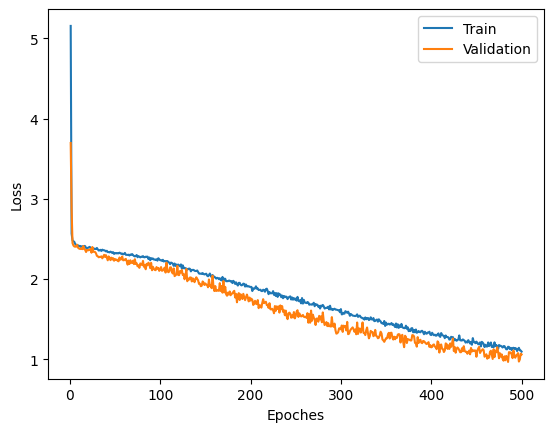

In [11]:
plotLoss(history)


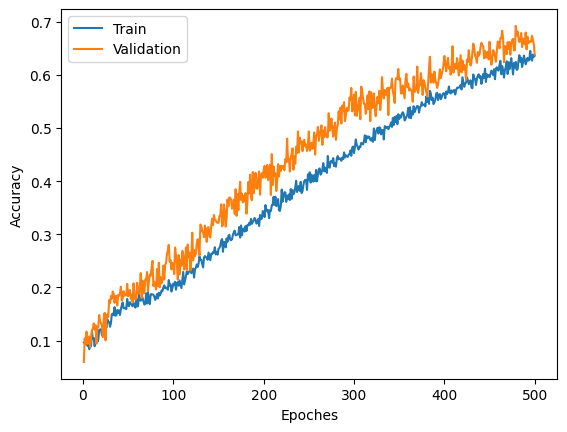

In [12]:
plotAcc(history)


In [16]:
bestdModel, history = trainModel(model, n_epochs, do_semi, device, criterion, optimizer, train_loader, valid_loader)
lastModel = model


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 001/500 ] loss = 1.12845, acc = 0.62798


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 001/500 ] loss = 0.99203, acc = 0.68502


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 002/500 ] loss = 1.14103, acc = 0.62500


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 002/500 ] loss = 0.98728, acc = 0.66716


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 003/500 ] loss = 1.06572, acc = 0.64245


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 003/500 ] loss = 1.01828, acc = 0.69196


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 004/500 ] loss = 1.08218, acc = 0.64407


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 004/500 ] loss = 0.98345, acc = 0.66419


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 005/500 ] loss = 1.08198, acc = 0.64886


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 005/500 ] loss = 0.98952, acc = 0.67708


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 006/500 ] loss = 1.08820, acc = 0.65209


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 006/500 ] loss = 0.96533, acc = 0.70089


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 007/500 ] loss = 1.09507, acc = 0.63680


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 007/500 ] loss = 0.99386, acc = 0.67063


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 008/500 ] loss = 1.10365, acc = 0.63605


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 008/500 ] loss = 1.04389, acc = 0.66171


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 009/500 ] loss = 1.07311, acc = 0.65093


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 009/500 ] loss = 1.06677, acc = 0.66716


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 010/500 ] loss = 1.09442, acc = 0.63701


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 010/500 ] loss = 1.05104, acc = 0.66369


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 011/500 ] loss = 1.09403, acc = 0.63953


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 011/500 ] loss = 1.00879, acc = 0.68006


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 012/500 ] loss = 1.05658, acc = 0.66031


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 012/500 ] loss = 0.97954, acc = 0.68204


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 013/500 ] loss = 1.06921, acc = 0.64316


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 013/500 ] loss = 1.00211, acc = 0.67361


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 014/500 ] loss = 1.08678, acc = 0.64513


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 014/500 ] loss = 0.95086, acc = 0.71925


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 015/500 ] loss = 1.09061, acc = 0.63887


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 015/500 ] loss = 1.04194, acc = 0.68403


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 016/500 ] loss = 1.06746, acc = 0.65194


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 016/500 ] loss = 1.01207, acc = 0.68304


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 017/500 ] loss = 1.11006, acc = 0.63025


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 017/500 ] loss = 0.98830, acc = 0.68105


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 018/500 ] loss = 1.04857, acc = 0.65496


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 018/500 ] loss = 1.02835, acc = 0.68552


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 019/500 ] loss = 1.08654, acc = 0.64190


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 019/500 ] loss = 1.02262, acc = 0.66319


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 020/500 ] loss = 1.07591, acc = 0.65506


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 020/500 ] loss = 1.01895, acc = 0.67262


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 021/500 ] loss = 1.08803, acc = 0.64926


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 021/500 ] loss = 1.01343, acc = 0.67411


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 022/500 ] loss = 1.07235, acc = 0.63549


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 022/500 ] loss = 0.96346, acc = 0.69742


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 023/500 ] loss = 1.05504, acc = 0.63872


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 023/500 ] loss = 0.99191, acc = 0.68006


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 024/500 ] loss = 1.07437, acc = 0.64447


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 024/500 ] loss = 0.99262, acc = 0.68155


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 025/500 ] loss = 1.04396, acc = 0.66339


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 025/500 ] loss = 1.02737, acc = 0.67708


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 026/500 ] loss = 1.03712, acc = 0.65991


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 026/500 ] loss = 1.01072, acc = 0.67956


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 027/500 ] loss = 1.06633, acc = 0.65174


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 027/500 ] loss = 0.99527, acc = 0.69643


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 028/500 ] loss = 1.03206, acc = 0.66768


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 028/500 ] loss = 1.03978, acc = 0.66915


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 029/500 ] loss = 1.08156, acc = 0.64427


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 029/500 ] loss = 1.02154, acc = 0.66716


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 030/500 ] loss = 1.01775, acc = 0.66354


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 030/500 ] loss = 1.03125, acc = 0.67312


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 031/500 ] loss = 1.04855, acc = 0.65456


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 031/500 ] loss = 0.98155, acc = 0.70536


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 032/500 ] loss = 0.99670, acc = 0.67464


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 032/500 ] loss = 1.02809, acc = 0.66815


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 033/500 ] loss = 1.06811, acc = 0.64573


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 033/500 ] loss = 0.97752, acc = 0.68849


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 034/500 ] loss = 1.04808, acc = 0.65900


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 034/500 ] loss = 0.97422, acc = 0.68800


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 035/500 ] loss = 1.06045, acc = 0.64619


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 035/500 ] loss = 0.93083, acc = 0.71776


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 036/500 ] loss = 1.03781, acc = 0.65789


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 036/500 ] loss = 1.05037, acc = 0.68006


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 037/500 ] loss = 1.05014, acc = 0.66319


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 037/500 ] loss = 0.97134, acc = 0.69692


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 038/500 ] loss = 1.04148, acc = 0.66536


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 038/500 ] loss = 0.96978, acc = 0.70188


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 039/500 ] loss = 1.04910, acc = 0.65577


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 039/500 ] loss = 0.97398, acc = 0.69494


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 040/500 ] loss = 1.04532, acc = 0.65622


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 040/500 ] loss = 1.02149, acc = 0.65823


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 041/500 ] loss = 1.03253, acc = 0.66102


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 041/500 ] loss = 0.96989, acc = 0.68800


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 042/500 ] loss = 0.99392, acc = 0.67580


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 042/500 ] loss = 0.93442, acc = 0.70337


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 043/500 ] loss = 1.04111, acc = 0.66162


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 043/500 ] loss = 0.98629, acc = 0.68948


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 044/500 ] loss = 1.03336, acc = 0.65628


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 044/500 ] loss = 0.98845, acc = 0.68849


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 045/500 ] loss = 1.04893, acc = 0.65784


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 045/500 ] loss = 0.94564, acc = 0.70188


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 046/500 ] loss = 1.00763, acc = 0.67368


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 046/500 ] loss = 0.99344, acc = 0.68006


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 047/500 ] loss = 1.04761, acc = 0.65789


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 047/500 ] loss = 0.96460, acc = 0.69246


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 048/500 ] loss = 1.00375, acc = 0.66904


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 048/500 ] loss = 0.96827, acc = 0.70089


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 049/500 ] loss = 1.02471, acc = 0.66339


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 049/500 ] loss = 0.99124, acc = 0.70635


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 050/500 ] loss = 1.01260, acc = 0.66884


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 050/500 ] loss = 0.98897, acc = 0.68155


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 051/500 ] loss = 1.02248, acc = 0.66127


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 051/500 ] loss = 0.94883, acc = 0.68452


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 052/500 ] loss = 1.04038, acc = 0.65239


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 052/500 ] loss = 0.91491, acc = 0.71329


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 053/500 ] loss = 1.00338, acc = 0.66803


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 053/500 ] loss = 0.97228, acc = 0.70337


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 054/500 ] loss = 0.98287, acc = 0.67312


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 054/500 ] loss = 0.97014, acc = 0.69296


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 055/500 ] loss = 1.02444, acc = 0.66127


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 055/500 ] loss = 0.94176, acc = 0.68552


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 056/500 ] loss = 1.01450, acc = 0.67716


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 056/500 ] loss = 0.91019, acc = 0.70337


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 057/500 ] loss = 0.99814, acc = 0.66349


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 057/500 ] loss = 0.96542, acc = 0.69494


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 058/500 ] loss = 1.00649, acc = 0.66667


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 058/500 ] loss = 1.00276, acc = 0.68056


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 059/500 ] loss = 0.99001, acc = 0.67731


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 059/500 ] loss = 0.97843, acc = 0.68800


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 060/500 ] loss = 1.02053, acc = 0.65814


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 060/500 ] loss = 0.96596, acc = 0.68552


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 061/500 ] loss = 0.99432, acc = 0.67327


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 061/500 ] loss = 0.98748, acc = 0.69544


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 062/500 ] loss = 1.00215, acc = 0.67852


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 062/500 ] loss = 0.95697, acc = 0.69494


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 063/500 ] loss = 0.99920, acc = 0.66979


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 063/500 ] loss = 0.94830, acc = 0.70685


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 064/500 ] loss = 0.98481, acc = 0.69048


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 064/500 ] loss = 1.09925, acc = 0.67609


  0%|          | 0/59 [00:00<?, ?it/s]

[ Train | 065/500 ] loss = 1.01452, acc = 0.66757


  0%|          | 0/14 [00:00<?, ?it/s]

[ Valid | 065/500 ] loss = 0.99382, acc = 0.67659


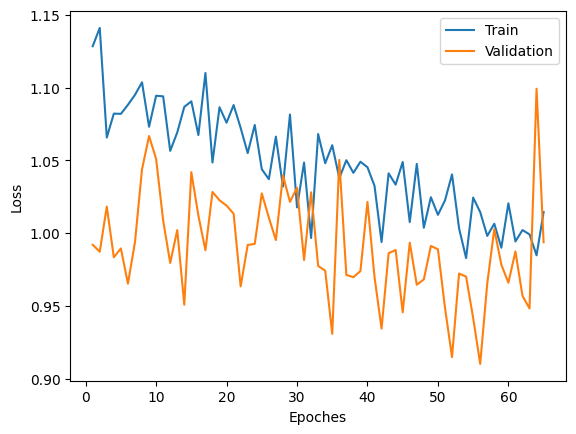

In [17]:
plotLoss(history)


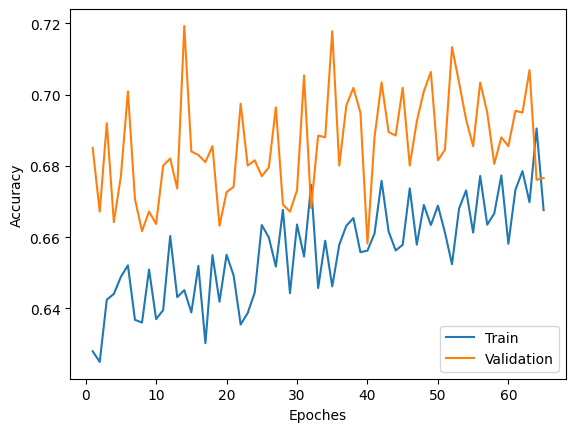

In [18]:
plotAcc(history)


## Testing


In [19]:
# modelPath = "model/modelName/savedName.pth"
# bestdModel.load_state_dict(torch.load(modelPath, map_location=device))


In [20]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
bestdModel.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = bestdModel(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


  0%|          | 0/67 [00:00<?, ?it/s]

In [21]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
